# Exploratory Data Analysis

This notebook is for doing data checks and quick visualizations. 

In [1]:
# standard import
# warnings
import warnings

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# advanced analytics
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# establish database connections
conn = duckdb.connect("../data/lake/database.duckdb")

## Overview

Load and merge tables. 

In [2]:
# climate_atmosphere data
climate_df = conn.sql("""
    SELECT
        date,
        adm3_en,
        adm3_pcode,
        adm4_en,
        adm4_pcode,
        tave,
        pr
    FROM public.project_cchain_climate_atmosphere_clean
    WHERE date >= '2020-01-01' AND date < '2022-12-31'
    ORDER BY date
    """).fetchdf()

climate_df = climate_df.drop_duplicates().reset_index()
climate_df["date"] = pd.to_datetime(climate_df["date"])
climate_df = climate_df.set_index("date")

daily_avg_df = (
    climate_df.groupby("adm3_pcode")
    .resample("D")
    .agg(
        {
            "adm3_en": "first",
            "adm4_pcode": "first",
            "tave": "mean",
            "pr": "mean",  # average per day
        }
    )
    .reset_index()
)

climate_df = (
    daily_avg_df.groupby("adm3_pcode")
    .resample("W-Mon", on="date")
    .agg(
        {
            "adm3_en": "first",
            "tave": "mean",
            "pr": "sum",  # sum per week
        }
    )
    .reset_index()
)

climate_df = climate_df[climate_df["date"] != "2023-01-02"]

climate_df.head(5)

,adm3_pcode,date,adm3_en,tave,pr
0,PH015518000,2020-01-06,Dagupan City,26.772364,0.0
1,PH015518000,2020-01-13,Dagupan City,26.612350,0.0
2,PH015518000,2020-01-20,Dagupan City,26.675714,0.0
3,PH015518000,2020-01-27,Dagupan City,26.099077,0.0
4,PH015518000,2020-02-03,Dagupan City,25.076405,0.0


In [3]:
# dengue data
dengue_df = conn.sql("""
    SELECT
        date,
        adm3_en,
        adm3_pcode,
        disease_common_name,
        case_total
    FROM public.project_cchain_disease_pidsr_totals_clean
    WHERE date >= '2020-01-01' AND date < '2022-12-31'
    """).fetchdf()

dengue_df = dengue_df.drop_duplicates().reset_index(drop=True)
dengue_df["date"] = pd.to_datetime(dengue_df["date"])
dengue_df = dengue_df.pivot(
    index=["date", "adm3_en", "adm3_pcode"],
    columns="disease_common_name",
    values="case_total",
).reset_index()

dengue_df = dengue_df.rename(
    columns={
        "ACUTE BLOODY DIARRHEA": "diarrhea_cases",
        "CHIKUNGUYA VIRAL DISEASE": "chikungunya_cases",
        "CHOLERA": "cholera_cases",
        "DENGUE FEVER": "dengue_cases",
        "HEPATITIS A": "hepa_a_cases",
        "LEPTOSPIROSIS": "lepto_cases",
        "RABIES": "rabies_cases",
        "ROTAVIRAL ENTERITIS": "rotavirus_cases",
        "TYPHOID FEVER": "typhoid_cases",
    }
)

dengue_df.head(5)

disease_common_name,date,adm3_en,adm3_pcode,diarrhea_cases,chikungunya_cases,cholera_cases,dengue_cases,hepa_a_cases,lepto_cases,rabies_cases,rotavirus_cases,typhoid_cases
0,2020-01-06,Cagayan de Oro City,PH104305000,1,0,0,61,0,0,0,0,1
1,2020-01-06,City of Mandaluyong,PH137401000,0,0,0,58,0,0,0,0,0
2,2020-01-06,City of Muntinlupa,PH137603000,0,0,0,37,0,0,0,0,0
3,2020-01-06,City of Navotas,PH137503000,0,0,0,33,0,0,0,0,0
4,2020-01-06,Dagupan City,PH015518000,0,0,0,11,0,0,0,0,1


In [4]:
# merged_df
merged_df = pd.merge(
    climate_df, dengue_df, on=["date", "adm3_en", "adm3_pcode"], how="left"
)
merged_df.set_index("date", inplace=True)
merged_df.head(5)

,adm3_pcode,adm3_en,tave,pr,diarrhea_cases,chikungunya_cases,cholera_cases,dengue_cases,hepa_a_cases,lepto_cases,rabies_cases,rotavirus_cases,typhoid_cases
date,,,,,,,,,,,,,
2020-01-06,PH015518000,Dagupan City,26.772364,0.0,0,0,0,11,0,0,0,0,1
2020-01-13,PH015518000,Dagupan City,26.612350,0.0,0,0,0,2,1,0,0,0,0
2020-01-20,PH015518000,Dagupan City,26.675714,0.0,0,0,0,11,0,1,0,0,0
2020-01-27,PH015518000,Dagupan City,26.099077,0.0,0,0,0,6,0,0,0,0,0
2020-02-03,PH015518000,Dagupan City,25.076405,0.0,0,0,0,7,0,0,0,0,0


## Descriptive statistics

In [5]:
# descriptive stats
describe_df = merged_df.groupby(["adm3_pcode", "adm3_en"]).describe().reset_index()
describe_df.head(5)

adm3_pcode       adm3_en   tave                                  \
                              count       mean       std        min   
0  PH015518000  Dagupan City  156.0  27.944429  1.091912  25.076405   
1  PH034919000  Palayan City  156.0  26.846235  1.287879  23.719324   
2  PH050506000  Legazpi City  156.0  27.151518  0.995232  24.720938   
3  PH063022000   Iloilo City  156.0  27.416317  0.869270  25.410000   
4  PH072230000  Mandaue City  156.0  27.179083  0.580826  25.748888   

                                               ... rotavirus_cases       \
         25%        50%        75%        max  ...             75%  max   
0  27.277937  27.907282  28.555276  31.149584  ...             0.0  8.0   
1  26.021277  26.854887  27.738177  30.520300  ...             0.0  0.0   
2  26.356428  27.251775  27.845899  29.627390  ...             0.0  0.0   
3  26.870000  27.402143  27.877857  30.547144  ...             0.0  0.0   
4  26.823770  27.241032  27.527658  28.761904  ...             0.0  0.0   

  typhoid_cases                                                
          count      mean       std  min  25%  50%  75%   max  
0         156.0  0.833333  1.140647  0.0  0.0  0.0  1.0   4.0  
1         156.0  0.006410  0.080064  0.0  0.0  0.0  0.0   1.0  
2         156.0  0.044872  0.207689  0.0  0.0  0.0  0.0   1.0  
3         156.0  1.942308  2.134933  0.0  0.0  1.0  3.0  11.0  
4         156.0  0.346154  0.639091  0.0  0.0  0.0  1.0   3.0  

[5 rows x 90 columns]

In [6]:
# mean by city
summary_df = merged_df.groupby(["adm3_pcode", "adm3_en"]).mean().reset_index()
summary_df.head(5)

,adm3_pcode,adm3_en,tave,pr,diarrhea_cases,chikungunya_cases,cholera_cases,dengue_cases,hepa_a_cases,lepto_cases,rabies_cases,rotavirus_cases,typhoid_cases
0,PH015518000,Dagupan City,27.944429,37.410614,0.019231,0.000000,0.000000,3.929487,0.038462,0.115385,0.000000,0.442308,0.833333
1,PH034919000,Palayan City,26.846235,44.139614,0.032051,0.000000,0.006410,4.711538,0.000000,0.012821,0.000000,0.000000,0.006410
2,PH050506000,Legazpi City,27.151514,73.721619,0.006410,0.000000,0.000000,0.512821,0.000000,0.096154,0.006410,0.000000,0.044872
3,PH063022000,Iloilo City,27.416313,48.963104,0.006410,0.012821,0.051282,28.044872,0.121795,2.339744,0.153846,0.000000,1.942308
4,PH072230000,Mandaue City,27.179083,37.991039,1.435897,0.051282,0.019231,9.948718,0.160256,0.153846,0.006410,0.000000,0.346154


## Regression

For this section onwards, we are showing visualizations for **precipitation**, **average temperature**, and **dengue**. 

In [7]:
# disease_list
disease_names = [
    # "diarrhea_cases",
    # "chikungunya_cases",
    # "cholera_cases",
    "dengue_cases",
    # "hepa_a_cases",
    # "lepto_cases",
    # "rabies_cases",
    # "rotavirus_cases",
    # "typhoid_cases",
]

# city list
# adm3_en_list = merged_df["adm3_en"].unique()
adm3_en_list = [
    "Dagupan City",
    # "Palayan City",
    # "Legazpi City",
    # "Iloilo City",
    # "Mandaue City",
    # "Tacloban City",
    # "Zamboanga City",
    # "Cagayan de Oro City",
    # "Davao City",
    "City of Mandaluyong",
    # "City of Navotas",
    # "City of Muntinlupa"
]

# climate variables list
climate_variables = ["tave", "pr"]

In [8]:
# prep data for regression
X = merged_df[climate_variables]
y = merged_df[disease_names]
X = sm.add_constant(X)

# fit regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           dengue_cases   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     52.68
Date:                Sun, 18 May 2025   Prob (F-statistic):           5.52e-23
Time:                        21:05:19   Log-Likelihood:                -8752.6
No. Observations:                1872   AIC:                         1.751e+04
Df Residuals:                    1869   BIC:                         1.753e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        157.1227     14.295     10.992      0.0

## Visualizations

### Time series (seasonal decomposition)

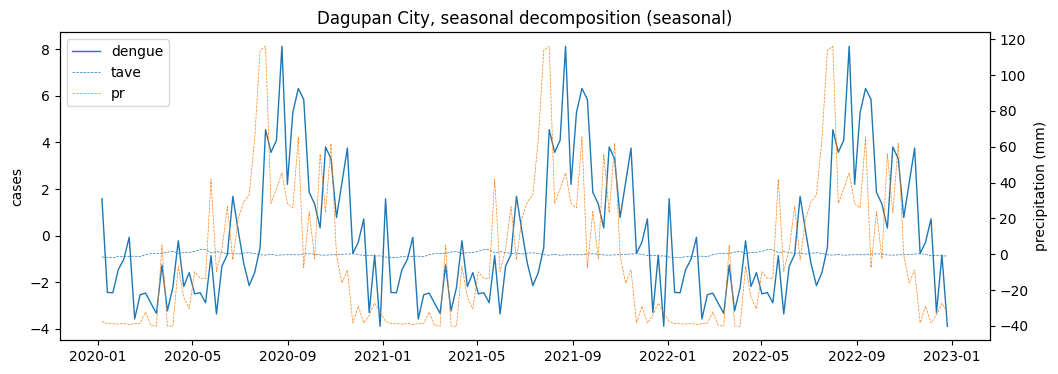

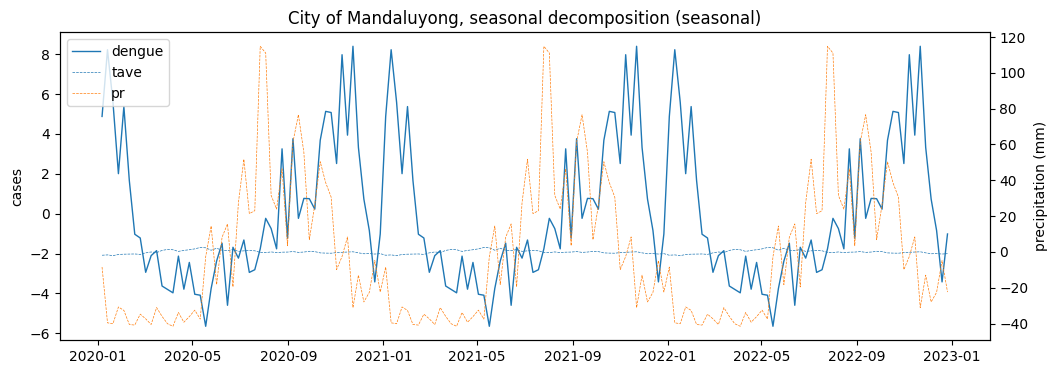

In [9]:
# seasonal decomposition details
seasonal_decompose_model = "additive"  # additive | multiplicative
component = "seasonal"  # observed | trend | seasonal | resid

for adm3 in adm3_en_list:
    adm3_data = merged_df[merged_df["adm3_en"] == adm3]

    plt.figure(figsize=(12, 4))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    for disease in disease_names:
        if disease in adm3_data.columns:
            disease_decomposition = sm.tsa.seasonal_decompose(
                adm3_data[disease], model=seasonal_decompose_model
            )
            disease_component = getattr(disease_decomposition, component)
            ax1.plot(
                disease_component.index,
                disease_component,
                label=disease.replace("_cases", ""),
                linewidth=1,
            )

    for climate_var in climate_variables:
        if climate_var in adm3_data.columns:
            climate_var_decomposition = sm.tsa.seasonal_decompose(
                adm3_data[climate_var], model=seasonal_decompose_model
            )
            climate_var_component = getattr(climate_var_decomposition, component)
            ax2.plot(
                climate_var_component.index,
                climate_var_component,
                label=climate_var,
                linewidth=0.5,
                linestyle="--",
            )

    ax1.set_title(f"{adm3}, seasonal decomposition ({component})")
    ax1.set_ylabel("cases")
    ax2.set_ylabel("precipitation (mm)")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.show()

### Correlation

In [10]:
correlation_matrices = []

for adm3 in adm3_en_list:
    adm3_data = merged_df[merged_df["adm3_en"] == adm3]

    correlation_matrix = adm3_data[disease_names + climate_variables].corr()
    correlation_matrix["adm3_en"] = adm3
    correlation_matrices.append(correlation_matrix)

correlation_df = pd.concat(correlation_matrices)
correlation_df = correlation_df.pivot(
    index=["adm3_en"], columns=[], values=disease_names + climate_variables
).reset_index()
# correlation_df.reset_index(inplace=True)
correlation_df.head(10)

,adm3_en,dengue_cases,tave,pr
0,Dagupan City,1.000000,-0.276726,0.275218
1,Dagupan City,-0.276726,1.000000,-0.020084
2,Dagupan City,0.275218,-0.020084,1.000000
3,City of Mandaluyong,1.000000,-0.286541,0.103826
4,City of Mandaluyong,-0.286541,1.000000,-0.125861
5,City of Mandaluyong,0.103826,-0.125861,1.000000


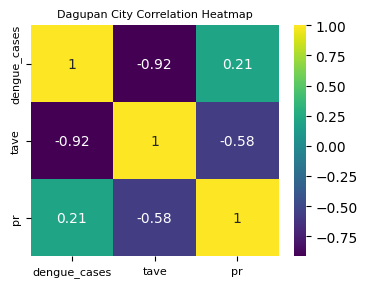

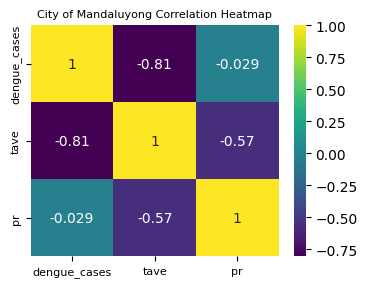

In [11]:
for adm3 in adm3_en_list:
    adm3_correlation_data = correlation_df[correlation_df["adm3_en"] == adm3]
    adm3_correlation_matrix = adm3_correlation_data.drop(columns=["adm3_en"])
    square_correlation_matrix = adm3_correlation_matrix.corr()

    plt.figure(figsize=(4, 3))
    sns.heatmap(square_correlation_matrix, annot=True, cmap="viridis", cbar=True)
    plt.title(f"{adm3} Correlation Heatmap", fontsize=8)
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

### Scatter Plot

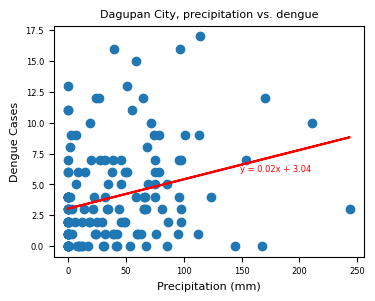

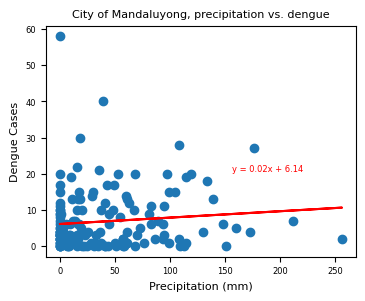

In [12]:
for adm3 in adm3_en_list:
    adm3_data = merged_df[merged_df["adm3_en"] == adm3]

    plt.figure(figsize=(4, 3))
    plt.scatter(adm3_data["pr"], adm3_data["dengue_cases"])

    m, b = np.polyfit(adm3_data["pr"], adm3_data["dengue_cases"], 1)  # 1 for linear fit
    plt.plot(adm3_data["pr"], m * adm3_data["pr"] + b, color="red", label="Trendline")
    equation = f"y = {m:.2f}x + {b:.2f}"

    plt.title(f"{adm3}, precipitation vs. dengue", fontsize=8)
    plt.xlabel("Precipitation (mm)", fontsize=8)
    plt.ylabel("Dengue Cases", fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.text(
        0.60,
        0.40,
        equation,
        transform=plt.gca().transAxes,
        fontsize=6,
        color="red",
        verticalalignment="top",
    )
    plt.show()

### Forecasting (ARIMA)

ARIMA Model Summary for Dagupan City:
                               SARIMAX Results                                
Dep. Variable:           dengue_cases   No. Observations:                  156
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -399.455
Date:                Sun, 18 May 2025   AIC                            804.910
Time:                        21:07:13   BIC                            814.021
Sample:                    01-06-2020   HQIC                           808.611
                         - 12-26-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4858      0.065     -7.488      0.000      -0.613      -0.359
ma.L1         -0.9998      3.176     -0.315      0.753      -7.224       5.224
sigma2        

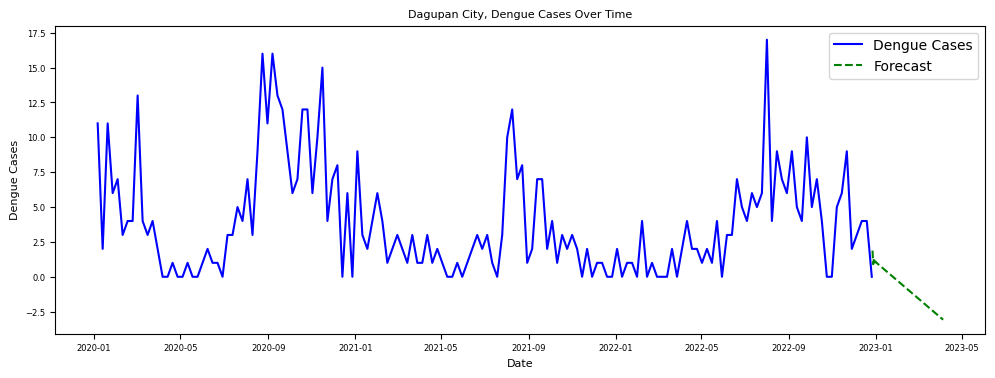

ARIMA Model Summary for City of Mandaluyong:
                               SARIMAX Results                                
Dep. Variable:           dengue_cases   No. Observations:                  156
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -481.748
Date:                Sun, 18 May 2025   AIC                            969.497
Time:                        21:07:13   BIC                            978.608
Sample:                    01-06-2020   HQIC                           973.197
                         - 12-26-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2878      0.057     -5.007      0.000      -0.400      -0.175
ma.L1         -0.9235      0.054    -17.137      0.000      -1.029      -0.818
sigma2 

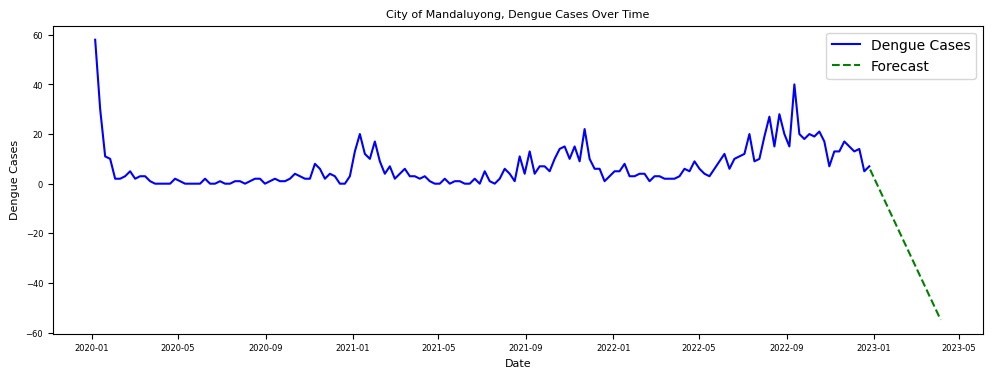

In [19]:
forecast_steps = 100

for adm3 in adm3_en_list:
    adm3_data = merged_df[merged_df["adm3_en"] == adm3].reset_index()

    adm3_data["date"] = pd.to_datetime(adm3_data["date"], errors="coerce")
    adm3_data = adm3_data.set_index("date")
    adm3_data = adm3_data.sort_index()

    dengue_series = adm3_data["dengue_cases"]

    # fit arima model
    model = ARIMA(dengue_series, order=(1, 2, 1))  # to-do: check arima order
    model_fit = model.fit()

    print(f"ARIMA Model Summary for {adm3}:")
    print(model_fit.summary())

    forecast = model_fit.forecast(steps=forecast_steps)
    forecast_index = pd.date_range(
        start=dengue_series.index[-1] + pd.Timedelta(days=1),
        periods=forecast_steps,
        freq="D",
    )

    plt.figure(figsize=(12, 4))
    plt.plot(
        dengue_series.index, dengue_series, label="Dengue Cases", color="blue"
    )  # historical
    plt.plot(
        forecast_index, forecast, color="green", label="Forecast", linestyle="--"
    )  # forecast

    plt.title(f"{adm3}, Dengue Cases Over Time", fontsize=8)
    plt.xlabel("Date", fontsize=8)
    plt.ylabel("Dengue Cases", fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.legend()
    plt.show()